In [2]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

class HarmonySearch:
    """Harmony Search Algorithm for dimensionality reduction"""
    def __init__(self, output_dim=2, hm_size=10, hmcr=0.9, par=0.3, bw=0.05):
        self.output_dim = output_dim
        self.hm_size = hm_size
        self.hmcr = hmcr
        self.par = par
        self.bw = bw
        self.harmony_memory = None
        self.memory_scores = None
        self.best_harmony = None
        self.best_score = float('inf')
        self.projected_data = None

    def stress(self, X, W):
        Y = X @ W
        orig_dist = np.linalg.norm(X[:, None] - X, axis=2)
        proj_dist = np.linalg.norm(Y[:, None] - Y, axis=2)
        return np.mean((orig_dist - proj_dist) ** 2)

    def initialize(self, data):
        input_dim = data.shape[1]
        self.harmony_memory = [np.random.randn(input_dim, self.output_dim) for _ in range(self.hm_size)]
        self.memory_scores = [self.stress(data, W) for W in self.harmony_memory]
        best_idx = np.argmin(self.memory_scores)
        self.best_harmony = self.harmony_memory[best_idx].copy()
        self.best_score = self.memory_scores[best_idx]

    def train(self, data, epochs):
        input_dim = data.shape[1]
        self.initialize(data)

        for epoch in range(epochs):
            new_harmony = np.zeros((input_dim, self.output_dim))

            for i in range(input_dim):
                for j in range(self.output_dim):
                    if np.random.rand() < self.hmcr:
                        idx = np.random.randint(self.hm_size)
                        new_harmony[i,j] = self.harmony_memory[idx][i,j]
                        if np.random.rand() < self.par:
                            new_harmony[i,j] += self.bw * (2 * np.random.rand() - 1)
                    else:
                        new_harmony[i,j] = np.random.randn()

            new_score = self.stress(data, new_harmony)

            worst_idx = np.argmax(self.memory_scores)
            if new_score < self.memory_scores[worst_idx]:
                self.harmony_memory[worst_idx] = new_harmony.copy()
                self.memory_scores[worst_idx] = new_score
                if new_score < self.best_score:
                    self.best_score = new_score
                    self.best_harmony = new_harmony.copy()

        self.projected_data = data @ self.best_harmony

    def quantization_error(self, data):
        if self.best_harmony is None or self.projected_data is None:
            return float('inf')
        projected_data = self.projected_data
        distances = pairwise_distances(projected_data)
        np.fill_diagonal(distances, np.inf)
        min_distances = np.min(distances, axis=1)
        return np.mean(min_distances)

hm_size=5, hmcr=0.7, par=0.1, bw=0.001, quant_error=0.20075
hm_size=5, hmcr=0.7, par=0.1, bw=0.005, quant_error=0.18209
hm_size=5, hmcr=0.7, par=0.1, bw=0.01, quant_error=0.19263
hm_size=5, hmcr=0.7, par=0.1, bw=0.05, quant_error=0.17536
hm_size=5, hmcr=0.7, par=0.1, bw=0.1, quant_error=0.15993
hm_size=5, hmcr=0.7, par=0.3, bw=0.001, quant_error=0.15866
hm_size=5, hmcr=0.7, par=0.3, bw=0.005, quant_error=0.15686
hm_size=5, hmcr=0.7, par=0.3, bw=0.01, quant_error=0.15167
hm_size=5, hmcr=0.7, par=0.3, bw=0.05, quant_error=0.18645
hm_size=5, hmcr=0.7, par=0.3, bw=0.1, quant_error=0.17094
hm_size=5, hmcr=0.7, par=0.5, bw=0.001, quant_error=0.15072
hm_size=5, hmcr=0.7, par=0.5, bw=0.005, quant_error=0.16862
hm_size=5, hmcr=0.7, par=0.5, bw=0.01, quant_error=0.15896
hm_size=5, hmcr=0.7, par=0.5, bw=0.05, quant_error=0.14758
hm_size=5, hmcr=0.7, par=0.5, bw=0.1, quant_error=0.17410
hm_size=5, hmcr=0.7, par=0.7, bw=0.001, quant_error=0.14486
hm_size=5, hmcr=0.7, par=0.7, bw=0.005, quant_error=

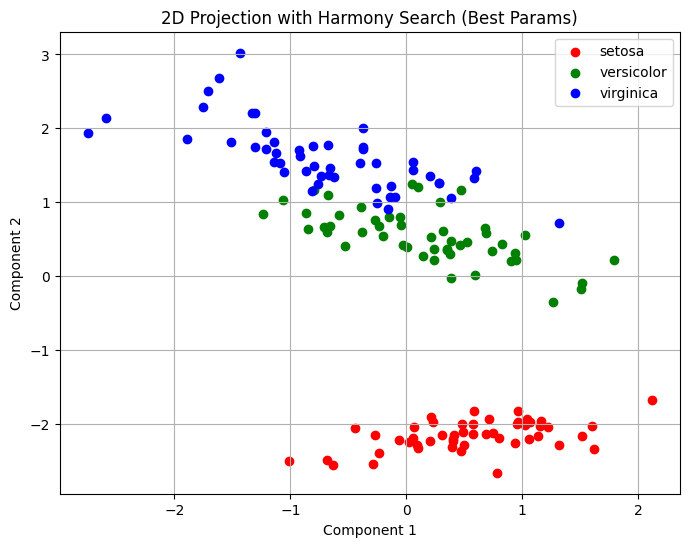

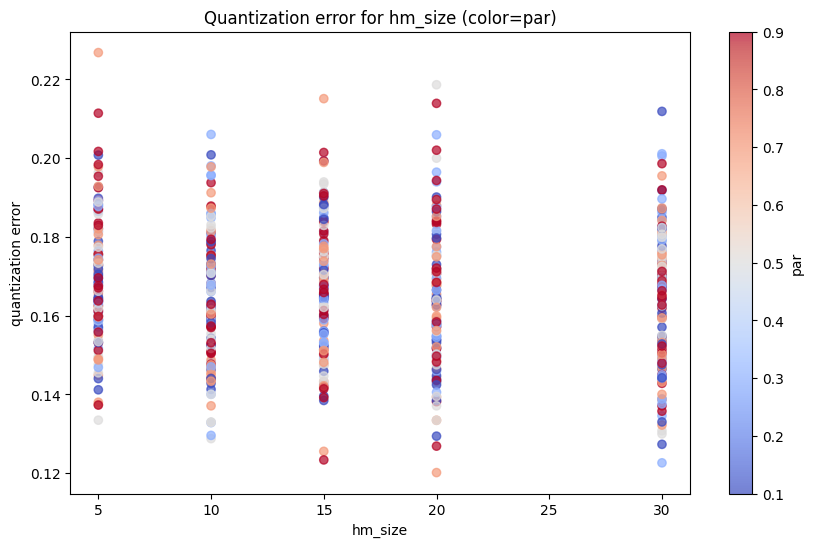

In [4]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === Paste your HarmonySearch class here ===

def tune_harmony_search(data, output_dim=2, epochs=100):
    param_grid = {
        'hm_size': [5, 10, 15, 20, 30],
        'hmcr':    [0.7, 0.8, 0.85, 0.9, 0.95],
        'par':     [0.1, 0.3, 0.5, 0.7, 0.9],
        'bw':      [0.001, 0.005, 0.01, 0.05, 0.1]
    }

    best_params = None
    best_q_error = float('inf')
    best_harmony = None
    best_projected = None
    results = []

    for hm_size in param_grid['hm_size']:
        for hmcr in param_grid['hmcr']:
            for par in param_grid['par']:
                for bw in param_grid['bw']:
                    hs = HarmonySearch(
                        output_dim=output_dim,
                        hm_size=hm_size,
                        hmcr=hmcr,
                        par=par,
                        bw=bw
                    )
                    hs.train(data, epochs=epochs)
                    q_error = hs.quantization_error(data)
                    print(f"hm_size={hm_size}, hmcr={hmcr}, par={par}, bw={bw}, quant_error={q_error:.5f}")
                    results.append({
                        'hm_size': hm_size,
                        'hmcr': hmcr,
                        'par': par,
                        'bw': bw,
                        'quant_error': q_error
                    })
                    if q_error < best_q_error:
                        best_q_error = q_error
                        best_params = {
                            'hm_size': hm_size,
                            'hmcr': hmcr,
                            'par': par,
                            'bw': bw
                        }
                        best_harmony = hs.best_harmony.copy()
                        best_projected = hs.projected_data.copy()
    return best_params, best_q_error, best_harmony, best_projected, results

# --- Main ---

data = load_iris().data
labels = load_iris().target
data = StandardScaler().fit_transform(data)
output_dim = 2
epochs = 200  # Increase for better results

best_params, best_q_error, best_harmony, best_projected, results = tune_harmony_search(
    data, output_dim, epochs
)

print("\nBest parameters found:")
print(best_params)
print("Lowest quantization error:", best_q_error)

# --- Visualization of projected data ---

plt.figure(figsize=(8,6))
for i, color, name in zip([0, 1, 2], ['r', 'g', 'b'], ['setosa', 'versicolor', 'virginica']):
    plt.scatter(best_projected[labels==i, 0], best_projected[labels==i, 1], c=color, label=name)
plt.title('2D Projection with Harmony Search (Best Params)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

# --- (Optional) Scatterplot of param search results ---
import pandas as pd

results_df = pd.DataFrame(results)
plt.figure(figsize=(10,6))
plt.scatter(results_df['hm_size'], results_df['quant_error'], c=results_df['par'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='par')
plt.xlabel('hm_size')
plt.ylabel('quantization error')
plt.title('Quantization error for hm_size (color=par)')
plt.show()